# Multiclass classification - Neural Network dataset(tfidf)

# Importing and Preprocessing

## Importing libraries

In [1]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [2]:
original_data = pd.read_pickle("../dataset/nn_cleaned.pkl")

## Preprocessing

In [3]:
df = original_data.copy()

#converting to lower case
# df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
# df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
# df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
# df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

# Gathering required features

In [4]:
short_df = df[['question','student_answer','student_modified','grade']]
# short_df['grades_round']= short_df['grade'].apply(lambda x: round(x))

# TFIDF

In [5]:
# Tf-idf creation
Tf = TfidfVectorizer()
tfidf_vector = Tf.fit_transform(df['student_modified'])
tfidf_vector = tfidf_vector.toarray()

X = tfidf_vector
Y = short_df['grade'].values

# Seeding

In [6]:
#getting the seed index
classes = short_df['grade'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['grade'][short_df['grade']==i].index[0])
seed_index

[0, 2, 88]

# Logistic Regression

In [7]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
lr = LogisticRegression()
# nb = MultinomialNB()
learner = ActiveLearner(
    estimator = lr,
#     estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X_pool, y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.515933
Accuracy after query no. 2: 0.515198
Accuracy after query no. 3: 0.514460
Accuracy after query no. 4: 0.515244
Accuracy after query no. 5: 0.516031
Accuracy after query no. 6: 0.498471
Accuracy after query no. 7: 0.499234
Accuracy after query no. 8: 0.516871
Accuracy after query no. 9: 0.516129
Accuracy after query no. 10: 0.515385
Accuracy after query no. 11: 0.516179
Accuracy after query no. 12: 0.515432
Accuracy after query no. 13: 0.516229
Accuracy after query no. 14: 0.515480
Accuracy after query no. 15: 0.516279
Accuracy after query no. 16: 0.515528
Accuracy after query no. 17: 0.516330
Accuracy after query no. 18: 0.515576
Accuracy after query no. 19: 0.516381
Accuracy after query no. 20: 0.518750
Accuracy after query no. 21: 0.541471
Accuracy after query no. 22: 0.521944
Accuracy after query no. 23: 0.547881
Accuracy after query no. 24: 0.559748
Accuracy after query no. 25: 0.548031
Accuracy after query no. 26: 0.548896
Accuracy after query 

# Multinomial Naive Bayes 

In [8]:
act_data = short_df.copy()
accuracy_list_nb = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list_nb.append(learner.score(X_pool, y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.142640
Accuracy after query no. 2: 0.363222
Accuracy after query no. 3: 0.458143
Accuracy after query no. 4: 0.173780
Accuracy after query no. 5: 0.377099
Accuracy after query no. 6: 0.501529
Accuracy after query no. 7: 0.192956
Accuracy after query no. 8: 0.404908
Accuracy after query no. 9: 0.485407
Accuracy after query no. 10: 0.235385
Accuracy after query no. 11: 0.479199
Accuracy after query no. 12: 0.498457
Accuracy after query no. 13: 0.321484
Accuracy after query no. 14: 0.422601
Accuracy after query no. 15: 0.365891
Accuracy after query no. 16: 0.360248
Accuracy after query no. 17: 0.360809
Accuracy after query no. 18: 0.362928
Accuracy after query no. 19: 0.400936
Accuracy after query no. 20: 0.492188
Accuracy after query no. 21: 0.560250
Accuracy after query no. 22: 0.548589
Accuracy after query no. 23: 0.532182
Accuracy after query no. 24: 0.529874
Accuracy after query no. 25: 0.552756
Accuracy after query no. 26: 0.570978
Accuracy after query 

## Regular supervised task

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)
lr = LogisticRegression()
lr.fit(X_train, Y_train)
score_lr = lr.score(X_test, Y_test)
score_lr

0.6015037593984962

In [11]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)
nb = MultinomialNB()
nb.fit(X_train, Y_train)
score_nb = nb.score(X_test, Y_test)
score_nb

0.6015037593984962

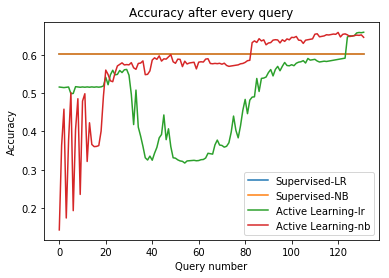

In [12]:
supervised_accuracy_lr = [score_lr for x in range(0,n_queries)]
supervised_accuracy_nb = [score_nb for x in range(0,n_queries)]


plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy_lr)
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy_nb)
plt.plot(accuracy_list)
plt.plot(accuracy_list_nb)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised-LR", "Supervised-NB","Active Learning-lr","Active Learning-nb"], loc="lower right")
plt.show()

In [23]:
tfidf_vector#checking the baseline
len(df[df['grade'] == 2]) / len(df)


0.5158371040723982

In [22]:
print(nb.predict(Tf.transform([" "])))

[2]


In [18]:
Tf.fit_transform("")

ValueError: Iterable over raw text documents expected, string object received.